In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-detection-human-faces-18-60-years/age_detection.csv
/kaggle/input/age-detection-human-faces-18-60-years/test/51-60/29.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/51-60/28.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/51-60/26.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/51-60/27.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/51-60/25.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/31-40/29.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/31-40/28.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/31-40/26.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/31-40/27.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/31-40/25.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/21-30/29.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/21-30/28.jpg
/kaggle/input/age-detection-human-faces-18-60-years/test/21-30/26.jpg
/kaggle/input/age-de

### IMPORTING IMPORTANT LIBRARIES

In [20]:
import matplotlib.pyplot as plt
import tensorflow 
import keras
from keras.models import Sequential,Model 
from keras.layers import Conv2D,Dense,Input,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping
import keras_tuner as k

In [21]:
### CREATING IMAGE DATA GENERATOR 
train=ImageDataGenerator(rotation_range=90,horizontal_flip=True,width_shift_range=0.5,
    height_shift_range=0.5,shear_range=0.4,
    zoom_range=0.5,rescale=1./255)
valid=ImageDataGenerator(rescale=1./255) 

In [22]:
traing=train.flow_from_directory('/kaggle/input/age-detection-human-faces-18-60-years/train',
                                target_size=(224,224),class_mode="sparse",
                                batch_size=8)

Found 125 images belonging to 5 classes.


In [23]:
validg=train.flow_from_directory('/kaggle/input/age-detection-human-faces-18-60-years/test',
                                target_size=(224,224),class_mode="sparse",
                                batch_size=8)

Found 25 images belonging to 5 classes.


### CREATING OUR MODEL FROM SCRATCH AND FINDING THE BEST MODEL WITH THE HELP OF KERAS TUNER 

In [24]:
def create_model(hp):
    model=Sequential()
    for i in range(hp.Int("conv and max pool",min_value=2,max_value=8,step=2)):
        model.add(Conv2D(filters=14,kernel_size=(3,3),padding="same"))
        model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding="valid"))
    model.add(Flatten())
    model.add(Dense(100,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(50,activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=5,activation="softmax"))
    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model 

In [25]:
tuner=k.RandomSearch(hypermodel=create_model,objective="val_accuracy",max_trials=3,
                     directory='/kaggle/working/tuned_model/',project_name="m4")

In [27]:
tuner.search(traing,epochs=10,steps_per_epoch=125//8,validation_data=validg,validation_steps=25//8)

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
conv and max pool (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}


In [29]:
tuner.results_summary()

Results summary
Results in /kaggle/working/tuned_model/m4
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
conv and max pool: 4
Score: 0.2916666567325592

Trial 2 summary
Hyperparameters:
conv and max pool: 8
Score: 0.25

Trial 1 summary
Hyperparameters:
conv and max pool: 2
Score: 0.2083333283662796


In [30]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it on the full dataset
model = tuner.hypermodel.build(best_hps)#tuner.get_best_hyperparameters


In [31]:
model.fit(traing, epochs=10, steps_per_epoch=125//8,
               validation_data=validg, validation_steps=25//8)

Epoch 1/10
15/15 [==============================] - 14s 738ms/step - loss: 2.0782 - accuracy: 0.1538 - val_loss: 10.7115 - val_accuracy: 0.1250
Epoch 2/10
15/15 [==============================] - 11s 749ms/step - loss: 1.8446 - accuracy: 0.2564 - val_loss: 7.6186 - val_accuracy: 0.2083
Epoch 3/10
15/15 [==============================] - 11s 753ms/step - loss: 1.7966 - accuracy: 0.2650 - val_loss: 3.2131 - val_accuracy: 0.3333
Epoch 4/10
15/15 [==============================] - 11s 720ms/step - loss: 1.7030 - accuracy: 0.2308 - val_loss: 2.7729 - val_accuracy: 0.2083
Epoch 5/10
15/15 [==============================] - 11s 758ms/step - loss: 1.6559 - accuracy: 0.2393 - val_loss: 5.0127 - val_accuracy: 0.1667
Epoch 6/10
15/15 [==============================] - 12s 781ms/step - loss: 1.6856 - accuracy: 0.2479 - val_loss: 1.9572 - val_accuracy: 0.2917
Epoch 7/10
15/15 [==============================] - 11s 760ms/step - loss: 1.5767 - accuracy: 0.2991 - val_loss: 2.2377 - val_accuracy: 0.083

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, None, None, 14)    392       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, None, None, 14)    0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 14)    1778      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, None, None, 14)    0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 14)    1778      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, None, None, 14)   

In [33]:
import matplotlib.pyplot as plt

In [34]:
es=EarlyStopping(monitor="val_loss",min_delta=0.01,patience=3,start_from_epoch=4,verbose=1) 

In [35]:
history=model.fit(traing, epochs=10, steps_per_epoch=125//8,
               validation_data=validg, validation_steps=25//8,callbacks=[es])

Epoch 1/10
15/15 [==============================] - 12s 821ms/step - loss: 1.7358 - accuracy: 0.2222 - val_loss: 3.1409 - val_accuracy: 0.1667
Epoch 2/10
15/15 [==============================] - 11s 747ms/step - loss: 1.6263 - accuracy: 0.1966 - val_loss: 2.7089 - val_accuracy: 0.2083
Epoch 3/10
15/15 [==============================] - 12s 785ms/step - loss: 1.5750 - accuracy: 0.2650 - val_loss: 2.0628 - val_accuracy: 0.2500
Epoch 4/10
15/15 [==============================] - 11s 764ms/step - loss: 1.6041 - accuracy: 0.2564 - val_loss: 1.8393 - val_accuracy: 0.2083
Epoch 5/10
15/15 [==============================] - 11s 759ms/step - loss: 1.5797 - accuracy: 0.2650 - val_loss: 1.6910 - val_accuracy: 0.2083
Epoch 6/10
15/15 [==============================] - 11s 763ms/step - loss: 1.6581 - accuracy: 0.1966 - val_loss: 1.7702 - val_accuracy: 0.1250
Epoch 7/10
15/15 [==============================] - 12s 766ms/step - loss: 1.6497 - accuracy: 0.1880 - val_loss: 2.6875 - val_accuracy: 0.2500

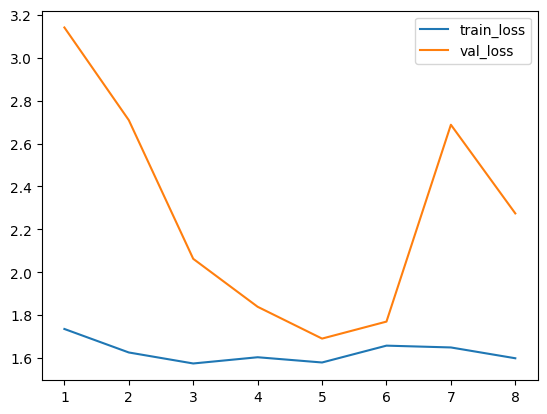

In [37]:
plt.plot(range(1,9),history.history["loss"],label="train_loss")
plt.plot(range(1,9),history.history["val_loss"],label="val_loss")
plt.legend()

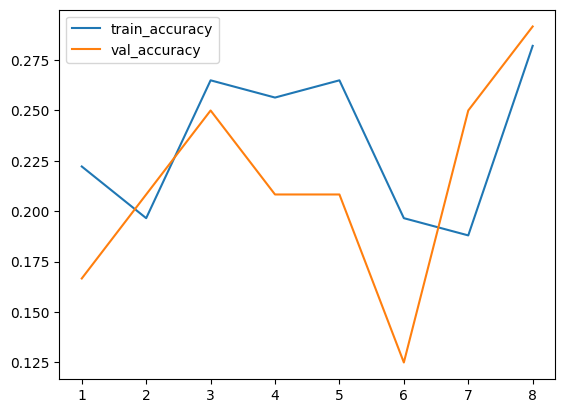

In [38]:
plt.plot(range(1,9),history.history["accuracy"],label="train_accuracy")
plt.plot(range(1,9),history.history["val_accuracy"],label="val_accuracy")
plt.legend()

In [43]:
predicted=model.predict(validg)
predicted

4/4 [==============================] - 2s 463ms/step


array([[0.28571156, 0.10324164, 0.19150865, 0.22357251, 0.19596569],
       [0.14708926, 0.03606117, 0.72529036, 0.08024144, 0.01131776],
       [0.15533468, 0.01761674, 0.7150905 , 0.08335496, 0.02860307],
       [0.19934978, 0.15535657, 0.4427743 , 0.15797473, 0.04454462],
       [0.13809095, 0.09555212, 0.14625573, 0.5154388 , 0.1046624 ],
       [0.05441571, 0.01524777, 0.8496135 , 0.07164124, 0.00908175],
       [0.1875161 , 0.04996055, 0.5522605 , 0.16229953, 0.04796331],
       [0.24870154, 0.21503389, 0.25583982, 0.15288526, 0.12753952],
       [0.07741956, 0.03305243, 0.8069148 , 0.07326606, 0.00934716],
       [0.20531677, 0.01919897, 0.7276838 , 0.03168213, 0.01611836],
       [0.09802359, 0.07227024, 0.677707  , 0.13572821, 0.01627098],
       [0.28204727, 0.12297797, 0.43461943, 0.0969236 , 0.0634317 ],
       [0.07220877, 0.01782532, 0.8020138 , 0.10158408, 0.00636804],
       [0.28351796, 0.05423994, 0.5557391 , 0.0758523 , 0.03065068],
       [0.1552432 , 0.062643  , 0.

In [45]:
predicted=np.argmax(predicted,axis=1)
predicted

array([0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2,
       2, 2, 0])

accuracy_score :  0.24


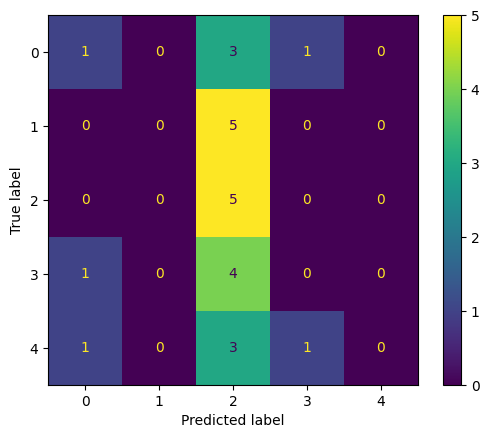

In [47]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
print("accuracy_score : ",accuracy_score(validg.labels,predicted)) 
cm=confusion_matrix(validg.labels,predicted)
va=ConfusionMatrixDisplay(cm)
va.plot() 
plt.show()